In [68]:
import pandas as pd
import requests as r
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import rasterio
import pystac_client
import planetary_computer
import statsmodels.api as sm

sys.path.append(os.path.abspath('..'))
from datetime import *     
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
import data_utils.vis as vis
import data_utils.data_helpers as data

### 1. Setting up elevation data per parcel using Python GIS Libraries

In [3]:
df_parcels = pd.read_csv('data/parcels/preprocessed_parcels_data.csv')

In [4]:
# pulling elevation data for all available properties 

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

tybee_bbox = [-80.86, 32.00, -80.83, 32.05]

search = catalog.search(
    collections=["3dep-seamless"],
    bbox=tybee_bbox
)

items = list(search.items()) 

if not items:
    print("CRITICAL ERROR: Could not find any 3DEP data for Tybee Island.")
else:
    dem_asset = items[0].assets["data"] 
    dem_href = dem_asset.href
    print(f"Found data file: {dem_href}")
    print(f"Opening cloud data file and sampling {len(df_parcels)} properties...")
    
    coordinates = list(zip(df_parcels['Longitude'], df_parcels['Latitude']))
    
    elevations = []
    
    with rasterio.open(dem_href) as src:
        print("Querying elevations...")
        results_generator = src.sample(coordinates)
        
        for result in tqdm(results_generator, total=len(coordinates)):
            elevation_val = result[0]
            if elevation_val < -9000:
                elevations.append(pd.NA)
            else:
                elevations.append(elevation_val)

    df_parcels['Elevation'] = elevations
    print(df_parcels[['Latitude', 'Longitude', 'Elevation']].head())
    print(df_parcels['Elevation'].describe())

Found data file: https://ai4edataeuwest.blob.core.windows.net/3dep/Elevation/13/TIFF/n33w081/USGS_13_n33w081.tif?st=2025-12-07T17%3A13%3A53Z&se=2025-12-08T17%3A58%3A53Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-12-08T15%3A51%3A53Z&ske=2025-12-15T15%3A51%3A53Z&sks=b&skv=2025-07-05&sig=R%2BT7/tfBmi2oGrgvanVKACIUo6xHjBm0ct8M%2BFrYAko%3D
Opening cloud data file and sampling 12137 properties...
Querying elevations...


100%|██████████| 12137/12137 [00:00<00:00, 15446.29it/s]

    Latitude  Longitude Elevation
0  32.024256 -80.847243  5.255017
1  32.024256 -80.847243  5.255017
2  32.024256 -80.847243  5.255017
3  32.024256 -80.847243  5.255017
4  32.025120 -80.848704  1.375379
count     8570.000000
unique     110.000000
top          2.803348
freq      1142.000000
Name: Elevation, dtype: float64


There are 3000+ rows that have a NaN value for the elevation field. Plotting the coordinates of these rows against a random representative sample of rows with non-NaN elevation fields, we have the following figure (blue represents non-Nan, red represents Nan).

![Flood Risk Forecast Plot](resources/elevation.png)

In [5]:
# clean up the dataframe by imputing missing values
df_parcels['Elevation'].fillna(0, inplace=True)
df_parcels.head()

/var/folders/4v/q1spznf91t36ybznjd9h0g480000gn/T/ipykernel_40036/3062823188.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_parcels['Elevation'].fillna(0, inplace=True)
/var/folders/4v/q1spznf91t36ybznjd9h0g480000gn/T/ipykernel_40036/3062823188.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_parce

,Property Address,Year,Fair Market Value,Sale Price,Acres,Year Built,Latitude,Longitude,Elevation
0,37.0 PULASKI ST TYBEE ISLAND GA 31328.0 37 PUL...,2023,1330300.0,0.0,0.15,2003.0,32.024256,-80.847243,5.255017
1,33.0 PULASKI ST TYBEE ISLAND GA 31328.0 33 PUL...,2023,1347300.0,0.0,0.82,1936.0,32.024256,-80.847243,5.255017
2,29.0 PULASKI ST TYBEE ISLAND GA 31328.0 29 PUL...,2023,367400.0,0.0,0.59,1932.0,32.024256,-80.847243,5.255017
3,27.0 PULASKI ST TYBEE ISLAND GA 31328.0 27 PUL...,2023,838600.0,0.0,0.73,1932.0,32.024256,-80.847243,5.255017
4,6.0 NORTHSHORE DR TYBEE ISLAND GA 31328.0 6 NO...,2023,879500.0,0.0,0.04,1991.0,32.025120,-80.848704,1.375379


In [6]:
df_parcels.iloc[np.where(df_parcels['Elevation'] == 0)]['Year'].unique()

array([2023, 2020, 2021, 2022])

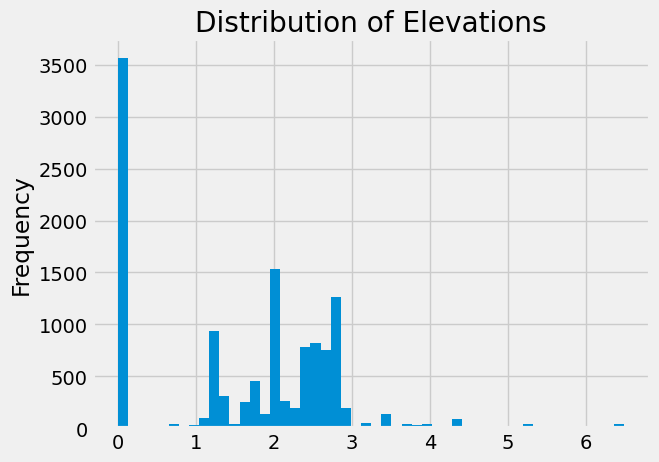

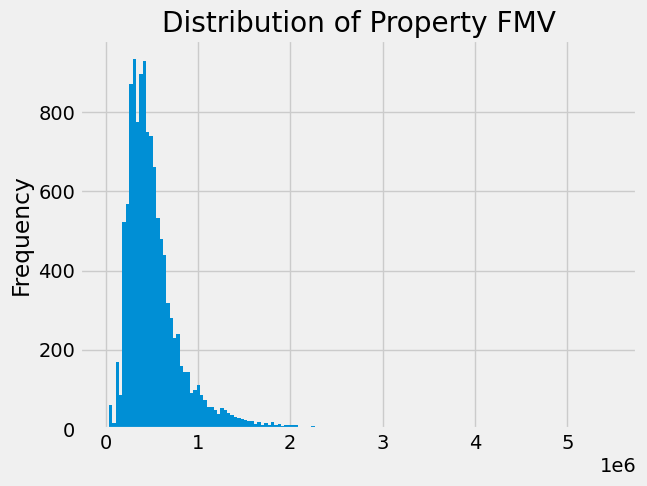

In [7]:
# visualizations 
vis.visualize_histogram(df_parcels['Elevation'], bins=50, title="Distribution of Elevations")
vis.visualize_histogram(df_parcels['Fair Market Value'], bins=150, title="Distribution of Property FMV")

np.float64(0.036461605461609335)

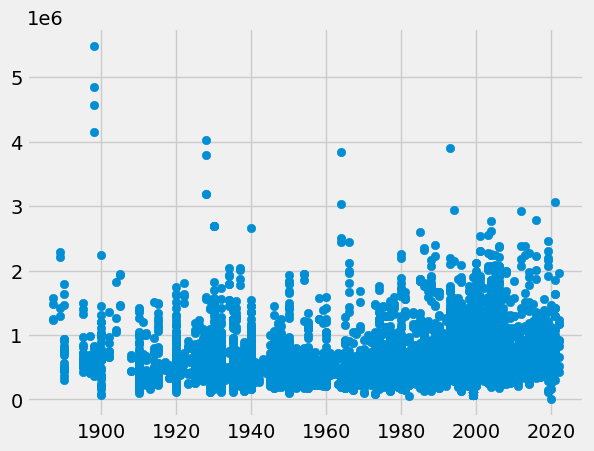

In [8]:
plt.scatter(df_parcels['Year Built'], df_parcels['Fair Market Value'])
np.corrcoef(df_parcels['Year Built'], df_parcels['Fair Market Value'])[0,1]

### 2. Setting up Water Level Data from SECOORA Data Feeds

Let us clean and process the data for the SECOORA water level feeds, from which we can engineer informative flood-related features to append to our parcel data. Plotting the time-series after filtering for outliers due to sensor observation noise, we'll see that there is a structural break in the time series data, attributable to a change in the sensor location and elevation around that date. 

In [9]:
df_water = pd.read_csv(
    'data/water_level/full_historical.csv', 
    #skiprows=[1], 
    parse_dates=['time']
)

In [10]:
'''df_water = df_water.drop(columns=[
    'water_surface_above_station_datum',
    'water_surface_above_navd88_surveyed_navd88_qc_agg',
    'water_surface_above_station_datum_qc_agg',
    'z'
])'''

df_water = df_water.dropna()
df_water = df_water.reset_index()
df_water = df_water.drop(columns=['index', 'Unnamed: 0'])
df_water = data.remove_outliers_by_range(
    df_water, 
    'result', 
    plausible_min= -4, 
    plausible_max= 4
)

#df_water = df_water.set_index('time')

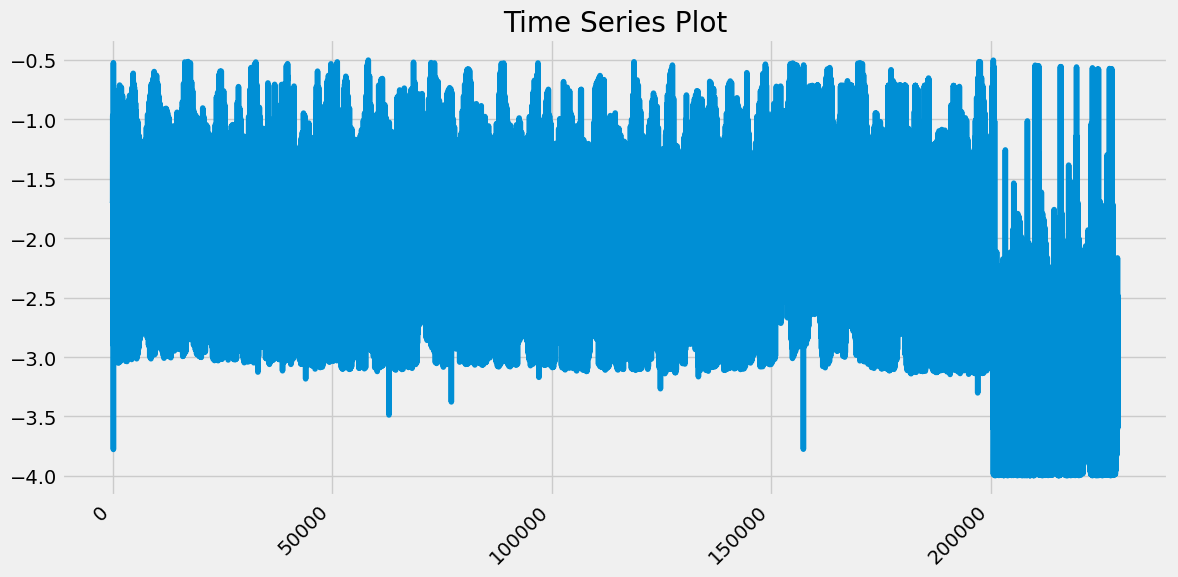

In [11]:
vis.visualize_time_series(df_water['result'])

In [12]:
df_water = df_water.copy() 

try:
    search_start_loc = 190000 
    search_end_loc = 204000
    
    if len(df_water) < search_end_loc:
        print("Warning: Data is shorter than the hard-coded search window.")
        search_end_loc = len(df_water) - 1

    search_slice = df_water.iloc[search_start_loc:search_end_loc]
    change_index = search_slice['result'].diff().idxmin()
    change_loc = df_water.index.get_loc(change_index)
    
    print(f"Sensor change detected at index: {change_index} (Row #{change_loc})")
    buffer = 50 
    mean_before = df_water['result'].iloc[change_loc - 1000 - buffer : change_loc - buffer].mean()
    mean_after = df_water['result'].iloc[change_loc + buffer : change_loc + 1000 + buffer].mean()
    
    shift_value = mean_before - mean_after
    
    print(f"Calculated shift value: {shift_value:.4f} (Your estimate was ~1.0)")
    df_water.loc[change_index:, 'result'] += shift_value
    
    print("Data shifted successfully.")

except Exception as e:
    print(f"An error occurred. Error: {e}")

#df_water = data.resample_dataframe(df_water, '1H')

Sensor change detected at index: 200643 (Row #200643)
Calculated shift value: 0.9754 (Your estimate was ~1.0)
Data shifted successfully.


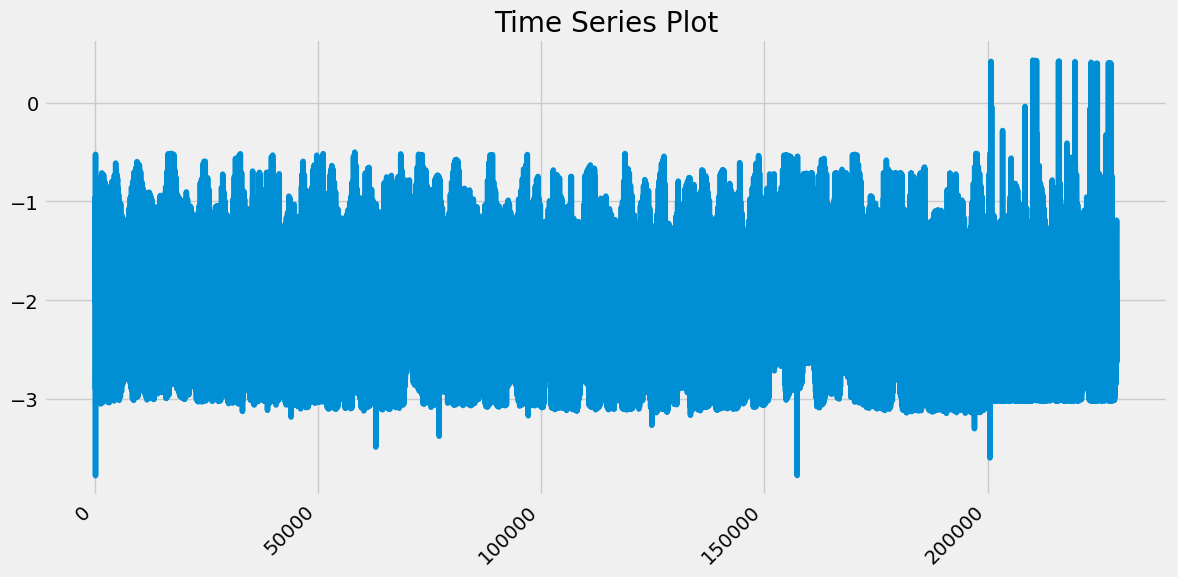

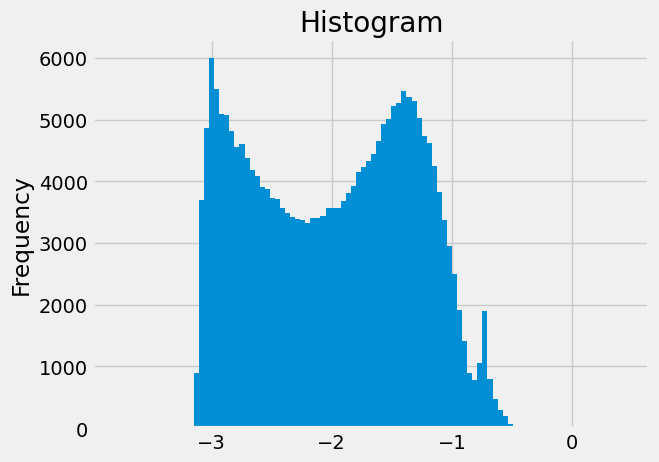

In [13]:
vis.visualize_time_series(df_water['result'])
vis.visualize_histogram(df_water['result'], bins=100)

In [14]:
df_water

,time,result
0,2021-09-01 21:53:14.103000+00:00,-1.698000
1,2021-09-01 21:58:27.454000+00:00,-1.696000
2,2021-09-01 22:03:40.253000+00:00,-1.698000
3,2021-09-01 22:08:48.372000+00:00,-1.700000
4,2021-09-01 22:14:01.222000+00:00,-1.701000
...,...,...
228979,2025-09-28 23:31:54.229972+00:00,-2.614552
228980,2025-09-28 23:37:02.675720+00:00,-2.607552
228981,2025-09-28 23:47:19.986915+00:00,-2.003552
228982,2025-09-28 23:52:28.701038+00:00,-2.599552


In [15]:
df_parcels

,Property Address,Year,Fair Market Value,Sale Price,Acres,Year Built,Latitude,Longitude,Elevation
0,37.0 PULASKI ST TYBEE ISLAND GA 31328.0 37 PUL...,2023,1330300.0,0.0,0.15,2003.0,32.024256,-80.847243,5.255017
1,33.0 PULASKI ST TYBEE ISLAND GA 31328.0 33 PUL...,2023,1347300.0,0.0,0.82,1936.0,32.024256,-80.847243,5.255017
2,29.0 PULASKI ST TYBEE ISLAND GA 31328.0 29 PUL...,2023,367400.0,0.0,0.59,1932.0,32.024256,-80.847243,5.255017
3,27.0 PULASKI ST TYBEE ISLAND GA 31328.0 27 PUL...,2023,838600.0,0.0,0.73,1932.0,32.024256,-80.847243,5.255017
4,6.0 NORTHSHORE DR TYBEE ISLAND GA 31328.0 6 NO...,2023,879500.0,0.0,0.04,1991.0,32.025120,-80.848704,1.375379
...,...,...,...,...,...,...,...,...,...
12132,103 12TH ST 103.0 12TH ST TYBEE ISLAND GA 31328.0,2022,496800.0,735000.0,0.11,1948.0,31.998507,-80.848464,0.000000
12133,37 PULASKI AVE 37.0 PULASKI AVE TYBEE ISLAND G...,2022,1164600.0,0.0,0.15,2003.0,32.024256,-80.847243,5.255017
12134,2 CARPENTER RD 2.0 CARPENTER RD TYBEE ISLAND G...,2022,220600.0,361000.0,0.09,1986.0,32.019577,-80.848929,1.233463
12135,13 11TH PL 13.0 11TH PL TYBEE ISLAND GA 31328.0,2022,524100.0,137000.0,0.08,1991.0,31.998338,-80.846038,0.000000


## Engineering Flood Risk Signals from Water Data

In [40]:
def add_flood_features(df_parcels, df_water):
    df_w = df_water.copy()
    if not isinstance(df_w.index, pd.DatetimeIndex):
        if 'time' in df_w.columns:
            df_w['time'] = pd.to_datetime(df_w['time'])
            df_w = df_w.set_index('time')
    
    target_col = 'result'
    if target_col not in df_w.columns:
        cols = [c for c in df_w.columns if 'navd88' in c.lower()]
        target_col = cols[0] if cols else df_w.columns[0]
        
    df_w = df_w.sort_index()
    
    results = []
    
    for year, group in df_parcels.groupby('Year'):
        try:
            w_year = df_w.loc[str(int(year))][target_col]
            if w_year.empty: raise KeyError
            
            w_values = w_year.values
            w_sorted = np.sort(w_values)
            n_samples = len(w_sorted)
            
            w_max = w_values.max()
            w_mean = w_values.mean()
            w_std = w_values.std()
            w_p50 = np.median(w_values)
            w_p90 = np.percentile(w_values, 90)
            w_p99 = np.percentile(w_values, 99)
            
            elevs = group['Elevation'].values
            
            group['Freeboard_Min'] = elevs - w_max
            group['Freeboard_Mean'] = elevs - w_mean
            group['Freeboard_P99'] = elevs - w_p99
            group['Freeboard_P90'] = elevs - w_p90
            group['Freeboard_Median'] = elevs - w_p50
            
            group['Risk_Ratio_Max'] = w_max / np.maximum(elevs, 0.1)
            group['Risk_Ratio_Mean'] = w_mean / np.maximum(elevs, 0.1)
            
            group['Z_Score_Risk'] = (elevs - w_mean) / (w_std + 1e-6)
            
            def count_exceedance(thresholds):
                indices = np.searchsorted(w_sorted, thresholds)
                return n_samples - indices

            group['Hours_Below_1ft'] = count_exceedance(elevs - 1.0)
            group['Hours_Below_2ft'] = count_exceedance(elevs - 2.0)
            group['Hours_Below_3ft'] = count_exceedance(elevs - 3.0)
            group['Hours_Below_5ft'] = count_exceedance(elevs - 5.0)
            group['Hours_Below_7ft'] = count_exceedance(elevs - 7.0)
            group['Hours_Below_10ft'] = count_exceedance(elevs - 10.0)
            
            group['Prob_Exceed_1ft'] = group['Hours_Below_1ft'] / n_samples
            group['Prob_Exceed_3ft'] = group['Hours_Below_3ft'] / n_samples
            
            group['Inv_Dist_Risk'] = 1.0 / np.maximum(group['Freeboard_Min'], 0.1)
            
            daily_max = w_year.resample('D').max().values
            d_sorted = np.sort(daily_max)
            n_days = len(d_sorted)
            
            group['Days_Below_1ft'] = n_days - np.searchsorted(d_sorted, elevs - 1.0)
            group['Days_Below_2ft'] = n_days - np.searchsorted(d_sorted, elevs - 2.0)
            group['Days_Below_3ft'] = n_days - np.searchsorted(d_sorted, elevs - 3.0)
            
            group['Yearly_Water_Max'] = w_max
            group['Yearly_Water_Mean'] = w_mean
            group['Yearly_Water_Std'] = w_std
            
        except (KeyError, ValueError):
            cols = ['Freeboard_Min', 'Freeboard_Mean', 'Freeboard_P99', 'Freeboard_P90', 'Freeboard_Median',
                    'Risk_Ratio_Max', 'Risk_Ratio_Mean', 'Z_Score_Risk', 'Hours_Below_1ft', 'Hours_Below_2ft',
                    'Hours_Below_3ft', 'Hours_Below_5ft', 'Hours_Below_7ft', 'Hours_Below_10ft',
                    'Prob_Exceed_1ft', 'Prob_Exceed_3ft', 'Inv_Dist_Risk', 'Days_Below_1ft',
                    'Days_Below_2ft', 'Days_Below_3ft', 'Yearly_Water_Max', 'Yearly_Water_Mean', 'Yearly_Water_Std']
            for c in cols:
                group[c] = 0
                
        results.append(group)
        
    return pd.concat(results).sort_index()

In [41]:
df_final = add_flood_features(df_parcels, df_water)
df_final

,Property Address,Year,Fair Market Value,Sale Price,Acres,Year Built,Latitude,Longitude,Elevation,Freeboard_Min,...,Hours_Below_10ft,Prob_Exceed_1ft,Prob_Exceed_3ft,Inv_Dist_Risk,Days_Below_1ft,Days_Below_2ft,Days_Below_3ft,Yearly_Water_Max,Yearly_Water_Mean,Yearly_Water_Std
0,37.0 PULASKI ST TYBEE ISLAND GA 31328.0 37 PUL...,2023,1330300.0,0.0,0.15,2003.0,32.024256,-80.847243,1.601729,2.102729,...,49281,0.000000,0.255738,0.475572,104,104,291,-0.501,-1.980196,0.677768
1,33.0 PULASKI ST TYBEE ISLAND GA 31328.0 33 PUL...,2023,1347300.0,0.0,0.82,1936.0,32.024256,-80.847243,1.601729,2.102729,...,49281,0.000000,0.255738,0.475572,104,104,291,-0.501,-1.980196,0.677768
2,29.0 PULASKI ST TYBEE ISLAND GA 31328.0 29 PUL...,2023,367400.0,0.0,0.59,1932.0,32.024256,-80.847243,1.601729,2.102729,...,49281,0.000000,0.255738,0.475572,104,104,291,-0.501,-1.980196,0.677768
3,27.0 PULASKI ST TYBEE ISLAND GA 31328.0 27 PUL...,2023,838600.0,0.0,0.73,1932.0,32.024256,-80.847243,1.601729,2.102729,...,49281,0.000000,0.255738,0.475572,104,104,291,-0.501,-1.980196,0.677768
4,6.0 NORTHSHORE DR TYBEE ISLAND GA 31328.0 6 NO...,2023,879500.0,0.0,0.04,1991.0,32.025120,-80.848704,0.419215,0.920215,...,49281,0.001461,0.734279,1.086702,120,291,292,-0.501,-1.980196,0.677768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12132,103 12TH ST 103.0 12TH ST TYBEE ISLAND GA 31328.0,2022,496800.0,735000.0,0.11,1948.0,31.998507,-80.848464,0.000000,0.517000,...,19763,0.049486,0.934676,1.934236,128,172,172,-0.517,-2.026503,0.690155
12133,37 PULASKI AVE 37.0 PULASKI AVE TYBEE ISLAND G...,2022,1164600.0,0.0,0.15,2003.0,32.024256,-80.847243,1.601729,2.118729,...,19763,0.000000,0.240449,0.471981,89,89,170,-0.517,-2.026503,0.690155
12134,2 CARPENTER RD 2.0 CARPENTER RD TYBEE ISLAND G...,2022,220600.0,361000.0,0.09,1986.0,32.019577,-80.848929,0.375960,0.892960,...,19763,0.004402,0.717148,1.119872,98,171,172,-0.517,-2.026503,0.690155
12135,13 11TH PL 13.0 11TH PL TYBEE ISLAND GA 31328.0,2022,524100.0,137000.0,0.08,1991.0,31.998338,-80.846038,0.000000,0.517000,...,19763,0.049486,0.934676,1.934236,128,172,172,-0.517,-2.026503,0.690155



Top 10 Drivers of Price:
            Feature  Importance
23   Days_Below_3ft    0.677288
21   Days_Below_1ft    0.083074
15  Hours_Below_5ft    0.041214
0             Acres    0.040409
7     Freeboard_P90    0.029059
2          Latitude    0.026956
3         Longitude    0.024943
1        Year Built    0.022021
4     Freeboard_Min    0.010533
9    Risk_Ratio_Max    0.009384


/var/folders/4v/q1spznf91t36ybznjd9h0g480000gn/T/ipykernel_40036/2500232962.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


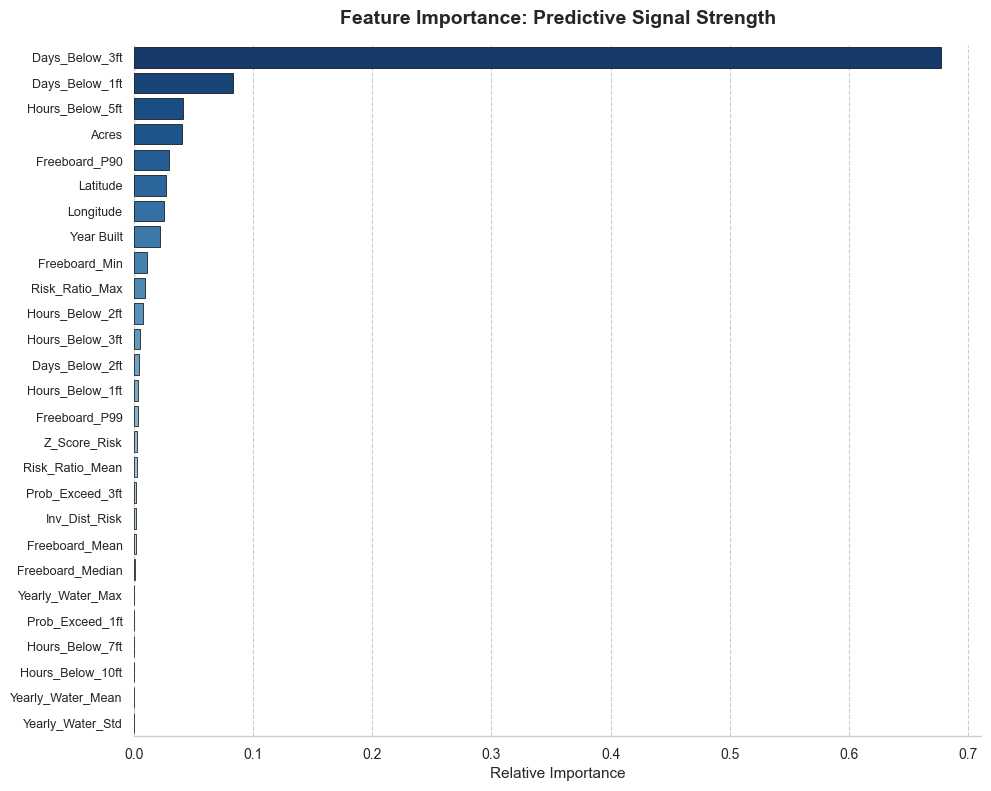


Direct Correlation (Freeboard vs Price): 0.1200


In [ ]:
def check_feature_signal(df):
    sns.set_context("paper")
    sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.5})
    
    flood_cols = [
        'Freeboard_Min', 'Freeboard_Mean', 'Freeboard_P99', 'Freeboard_P90', 'Freeboard_Median',
        'Risk_Ratio_Max', 'Risk_Ratio_Mean', 'Z_Score_Risk', 'Hours_Below_1ft', 'Hours_Below_2ft',
        'Hours_Below_3ft', 'Hours_Below_5ft', 'Hours_Below_7ft', 'Hours_Below_10ft',
        'Prob_Exceed_1ft', 'Prob_Exceed_3ft', 'Inv_Dist_Risk', 'Days_Below_1ft',
        'Days_Below_2ft', 'Days_Below_3ft', 'Yearly_Water_Max', 'Yearly_Water_Mean', 'Yearly_Water_Std'
        ]

    base_cols = ['Acres', 'Year Built', 'Latitude', 'Longitude']
    used_cols = [c for c in base_cols + flood_cols if c in df.columns]
    
    df_clean = df.dropna(subset=used_cols + ['Fair Market Value'])
    
    X = df_clean[used_cols]
    y = np.log(df_clean['Fair Market Value'])
    
    model = xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42, n_jobs=-1)
    model.fit(X, y)
    
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    print("\nTop 10 Drivers of Price:")
    print(importance.head(10))
    plt.figure(figsize=(10, 8))
    
    sns.barplot(
        data=importance, 
        x='Importance', 
        y='Feature', 
        palette='Blues_r', 
        edgecolor='black',
        linewidth=0.5
    )
    
    plt.title("Feature Importance: Predictive Signal Strength", fontsize=14, fontweight='bold', pad=15)
    plt.xlabel("Relative Importance", fontsize=11)
    plt.ylabel("")
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=9)
    sns.despine(left=True, bottom=False)
    
    plt.tight_layout()
    plt.savefig('feature_importance_pub_grade.png', dpi=300, bbox_inches='tight') # High res save
    plt.show()

    if 'Freeboard_Min' in df.columns:
        corr = df_clean['Freeboard_Min'].corr(df_clean['Fair Market Value'])
        print(f"\nDirect Correlation (Freeboard vs Price): {corr:.4f}")

check_feature_signal(df_final)

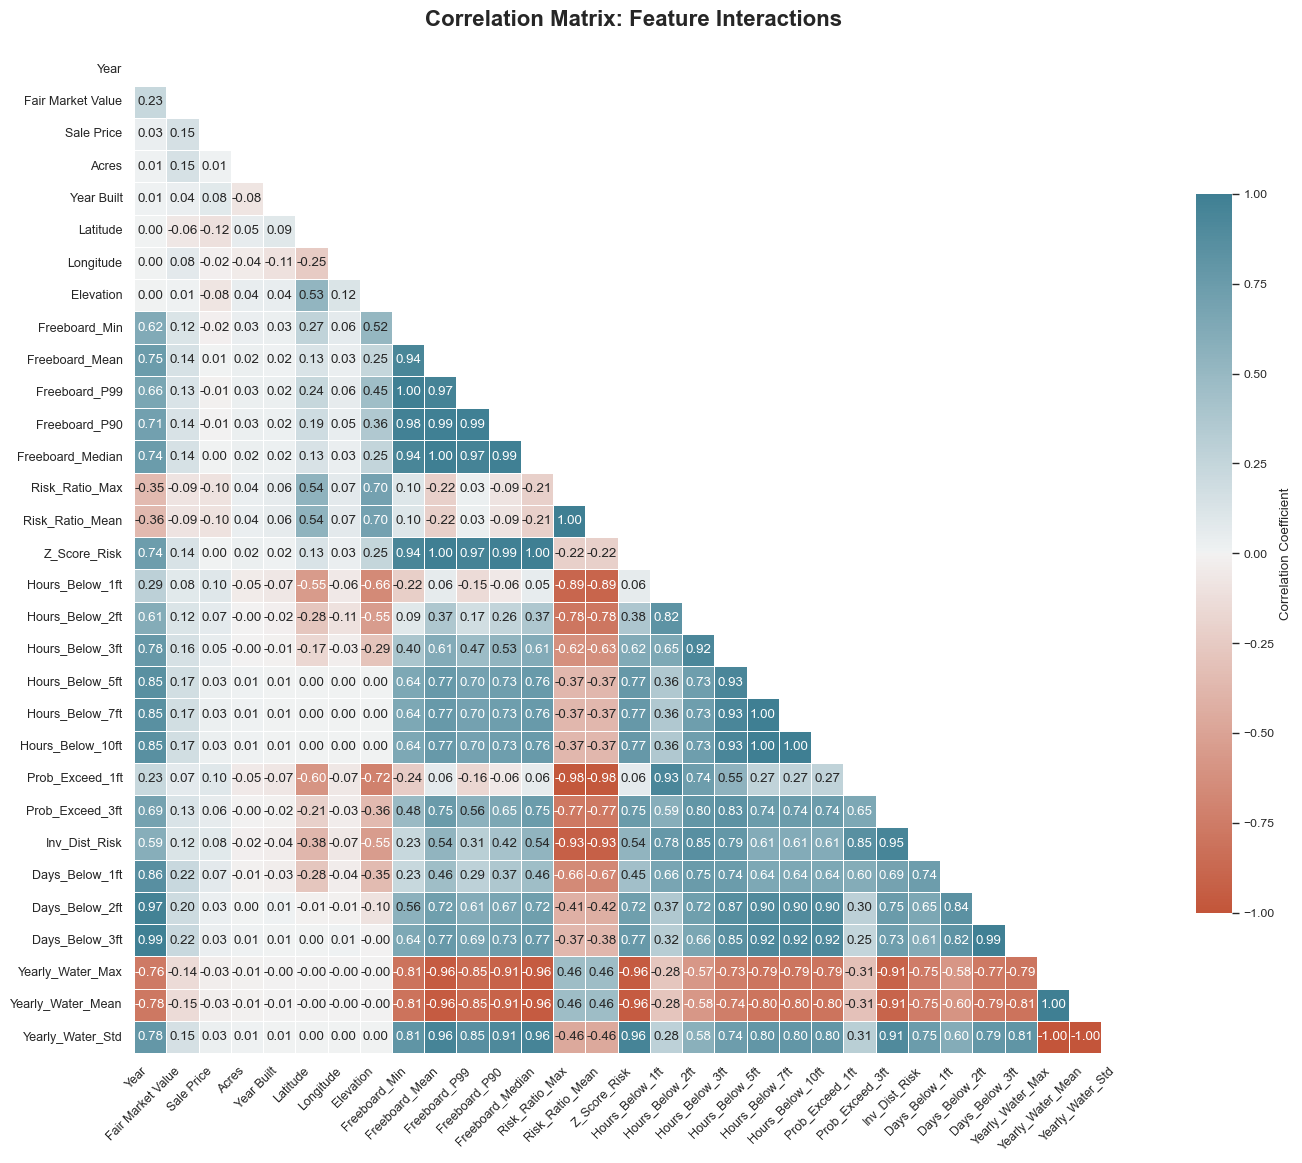

In [88]:
def plot_full_correlation_matrix(df):
    sns.set_context("paper")
    sns.set_style("white")
    df_numeric = df.select_dtypes(include=[np.number]).copy()
    
    corr = df_numeric.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(14, 12))
    cmap = sns.diverging_palette(20, 220, as_cmap=True)
    
    sns.heatmap(
        corr, 
        mask=mask, 
        cmap=cmap, 
        vmax=1, 
        vmin=-1, 
        center=0,
        square=True, 
        linewidths=0.5, 
        cbar_kws={"shrink": 0.7, "label": "Correlation Coefficient"},
        annot=True,
        fmt=".2f"
    )
    
    plt.title("Correlation Matrix: Feature Interactions", fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(fontsize=9)
    
    plt.tight_layout()
    plt.savefig('full_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_full_correlation_matrix(df_final)

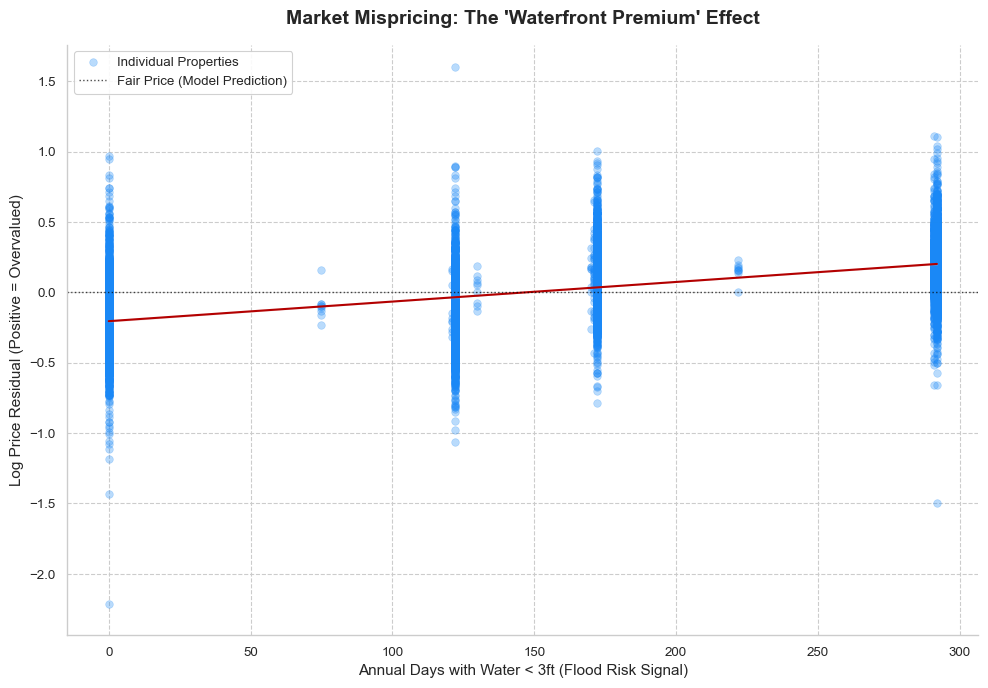

Correlation on plotted data: 0.5651


In [ ]:
standard_features = ['Acres', 'Year Built', 'Latitude', 'Longitude']
target = 'Fair Market Value'

df_model = df_final.dropna(subset=standard_features + [target, 'Days_Below_3ft']).copy()

X = df_model[standard_features]
y = np.log(df_model[target])

model = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42, n_jobs=-1)
model.fit(X, y)

df_model['Predicted_Log_Value'] = model.predict(X)
df_model['Price_Residual'] = np.log(df_model[target]) - df_model['Predicted_Log_Value']
df_plot = df_model[df_model['Price_Residual'] > -4.0].copy()
sns.set_context("paper", font_scale=1.1)
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.5, 'axes.edgecolor': '.8'})

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_plot,
    x='Days_Below_3ft',
    y='Price_Residual',
    alpha=0.3,
    color="#1A88F6",
    edgecolor=None,
    s=30,
    label='Individual Properties'
)

sns.regplot(
    data=df_plot,
    x='Days_Below_3ft',
    y='Price_Residual',
    scatter=False,
    color='#b30000',
    ci=95,
    line_kws={'label': 'Market Trend (OLS)', 'linewidth': 1.5}
)

plt.axhline(0, color='black', linestyle=':', linewidth=1, alpha=0.7, label='Fair Price (Model Prediction)')

plt.title("Market Mispricing: The 'Waterfront Premium' Effect", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Annual Days with Water < 3ft (Flood Risk Signal)", fontsize=11)
plt.ylabel("Log Price Residual (Positive = Overvalued)", fontsize=11)

plt.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9)
sns.despine(top=True, right=True)

plt.ylim(bottom=df_plot['Price_Residual'].min()*1.1, top=df_plot['Price_Residual'].max()*1.1)
plt.tight_layout()
plt.savefig('final_regression_analysis_pub.png', dpi=300, bbox_inches='tight')
plt.show()

corr_filtered = df_plot['Days_Below_3ft'].corr(df_plot['Price_Residual'])
print(f"Correlation on plotted data: {corr_filtered:.4f}")

In [84]:
X = df_model['Days_Below_1ft']
y = df_model['Price_Residual']
X = sm.add_constant(X)
model_stat = sm.OLS(y, X).fit()
print(model_stat.summary())

                            OLS Regression Results                            
Dep. Variable:         Price_Residual   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     4868.
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:59:14   Log-Likelihood:                 1271.3
No. Observations:               12137   AIC:                            -2539.
Df Residuals:                   12135   BIC:                            -2524.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1419      0.003    -50.

## Z-score of the Residuals